In [1]:
%matplotlib TkAgg

import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
from scipy.signal import butter, sosfilt, freqs

In [38]:
def standardizeMatrix(matrixOriginal):
    matrix = np.copy(matrixOriginal)

    floatType = type(matrix[0,0])
    rows, cols = matrix.shape
    matrix = matrix.astype(np.float64)
    
    for i in range(rows):
        mu = np.mean(matrix[i,:])
        sigma = np.std(matrix[i,:])
        matrix[i,:] = (matrix[i,:] - mu) / sigma
    return matrix.astype(floatType)


def elimPeaks(filteredMatrix, sigmaThreshold, sampleHalfWidthElim, sampleMinGap):

    standardizedMatrix = standardizeMatrix(filteredMatrix)
    peakList = []
    nChannel, nSample = standardizedMatrix.shape
    
    for i in range(nChannel):
        for j in range(nSample):
            if np.abs(standardizedMatrix[i,j]) > sigmaThreshold:
                peakList.append(j)
    peakList = list(set(peakList))
    peakList.sort()

    intervalList = [(thisPeak - sampleHalfWidthElim, thisPeak + sampleHalfWidthElim) for thisPeak in peakList]

    mergedIntervalList = [intervalList[0]]
    for i in range(1, len(intervalList)):
        currentInterval = mergedIntervalList[-1]
        nextInterval = intervalList[i]
        if currentInterval[1] + sampleMinGap >= nextInterval[0]:
            mergedIntervalList[-1] = (currentInterval[0], nextInterval[1])
        else:
            mergedIntervalList.append(nextInterval)
        
    startIndex = 0
    matrixList = []
    for i in range(0, len(mergedIntervalList)):
        intervalStart, intervalEnd = mergedIntervalList[i]
        thisMatrix = np.copy(filteredMatrix[:, startIndex:intervalStart])
        matrixList.append(thisMatrix)
        startIndex = intervalEnd + 1

    return matrixList, mergedIntervalList

In [3]:
filename = 'SVD001.edf'
raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)

Extracting EDF parameters from G:\My Drive\NeuroResearch\Data\eegCompress\ExampleLTMFiles\SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jetti\AppData\Local\Temp\ipykernel_23172\626497673.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)


In [4]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~39 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [5]:
goodChannels = ['Fp1','F3','C3','P3','O1','Fp2','F4','C4','P4','O2','F7','T7','P7','F8','T8','P8','Fz','Cz','Pz']

# Temp

In [17]:
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)
temp = raw.get_data()[chanList]
#temp = standardizeMatrix(temp)
tempList, intervalList = elimPeaks(temp, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

tempCat = np.concatenate(tempList, 1)

In [28]:
for block in range(9):
    print(tempList[block].shape)

(19, 144491)
(19, 669)
(19, 635)
(19, 345)
(19, 1080)
(19, 494)
(19, 383)
(19, 1100367)
(19, 824)


In [36]:
import lzma

block = 7
chanIndex = 0

chan = (tempList[block][chanIndex,:] * (10**6)).astype(np.int8)
#chan = (temp[0,:] * (10**6)).astype(np.int64)
chanDiff = np.diff(chan)
myCompress = lzma.compress(chanDiff, preset = 9)

print((len(chanDiff))/len(myCompress), np.max(np.abs(chanDiff)))

3.2611940298507465 13


In [37]:
chanDiff[0]

np.int8(3)

In [22]:
import lzma

block = 7
chanIndex = 0

for chanIndex in range(19):
    for block in range(7):

        chan = (tempList[block][chanIndex,:] * (10**6)).astype(np.int64)
        #chan = (temp[0,:] * (10**6)).astype(np.int64)
        chanDiff = np.diff(chan)
        myCompress = lzma.compress(chanDiff, preset = 9)

        print((len(chanDiff))/len(myCompress), np.max(np.abs(chanDiff)))

2.829143170426065 10
1.2846153846153847 6
1.2286821705426356 6
1.011764705882353 6
1.466032608695652 6
1.1518691588785046 6
1.0730337078651686 6
2.7507234236978375 10
1.2748091603053435 7
1.2192307692307693 8
0.9555555555555556 7
1.4581081081081082 8
1.1204545454545454 7
0.9947916666666666 7
2.8065029912205732 10
1.2651515151515151 8
1.268 8
1.0 7
1.4740437158469946 7
1.1307339449541285 7
1.0159574468085106 7
2.728285498489426 11
1.218978102189781 7
1.1654411764705883 9
0.945054945054945 7
1.4197368421052632 9
1.1204545454545454 7
0.9744897959183674 8
2.5720948447735688 14
1.1517241379310346 11
1.1569343065693432 12
0.9052631578947369 12
1.3762755102040816 11
0.9939516129032258 10
0.9182692307692307 11
2.6912904187155418 24
1.1597222222222223 8
1.1485507246376812 8
0.9662921348314607 7
1.4049479166666667 7
1.081140350877193 7
1.0268817204301075 7
2.8988443945108737 8
1.237037037037037 7
1.2192307692307693 7
0.9662921348314607 7
1.5069832402234637 7
1.1518691588785046 7
1.07303370786516

Creating RawArray with float64 data, n_channels=19, n_times=1249288
    Range : 0 ... 1249287 =      0.000 ...  4880.027 secs


Ready.


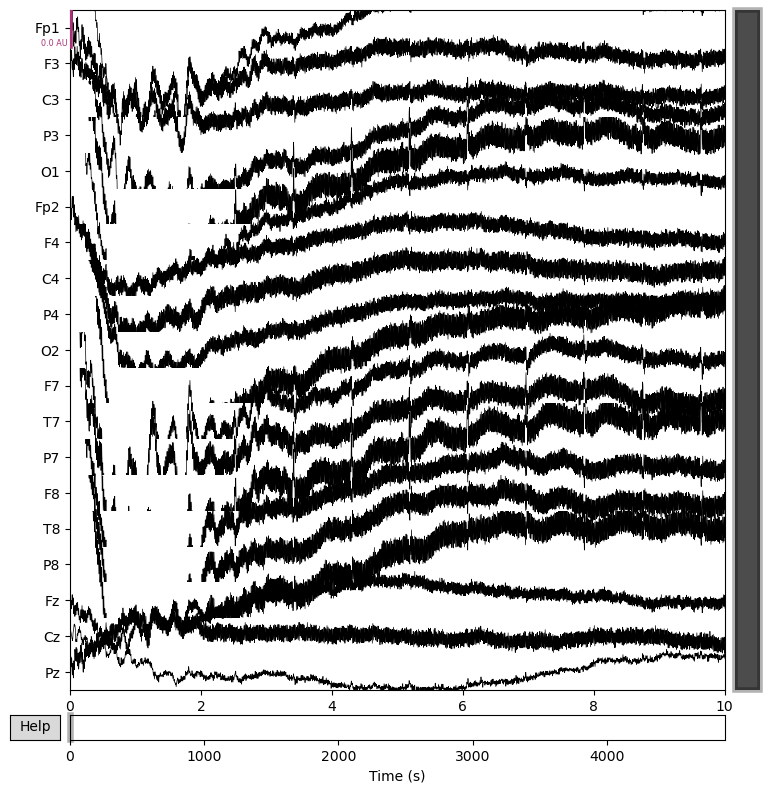

In [45]:
tempMatrix = tempCat

info = mne.create_info(goodChannels, 256)
tempRaw = mne.io.RawArray(tempMatrix, info)
tempRaw.plot()

# Temp End

In [6]:
lowPass = 40
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)

data = raw.get_data()[chanList]
nChannel, nSample = data.shape

sos = butter(30, [1,lowPass], 'bandpass', fs=256, output='sos')
dataFiltered = sosfilt(sos, data, -1)

#dataStandardized = standardizeMatrix(dataFiltered)
dataList, intervalList = elimPeaks(dataFiltered, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

In [7]:
plt.figure()
plt.plot(dataStandardized[0,:])

In [8]:
catData = np.concatenate(dataList,1)

plt.figure()
plt.plot(catData[0,:])

In [15]:
np.savez_compressed('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + 'processed' + filename[0:-4], *dataList)

# Scratch

In [ ]:
np.save('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + filename[0:-4], data)